# Corrected version (with more stable LinCKA2) version of the GTRL notebook

In [8]:
import numpy as np
import torch
from utils import *
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
import sys
from torch import nn

# 2 Gaussians translation exp

In [ ]:
median = 0.1

In [3]:
cuda = torch.device('cuda')

def get_cka_test(mean1 = 0,
                 mean2 = 0,
                 var1 = 1,
                 var2 = 1,
                 num_dims = 100,
                 num_pts = 1000,
                 seed = 0,
                 c = 1000,
                 verbose = False,
                 distribution = 'gaussian'):
    np.random.seed(seed)
    
    d = np.random.normal(0,1,[num_dims])
    d /= np.linalg.norm(d)
    
    if distribution == 'gaussian':
        X = np.concatenate( [np.random.normal(mean1, var1, [num_pts, num_dims]), np.random.normal(mean2, var2, [num_pts, num_dims])], axis = 0)
        Y = torch.Tensor(X + np.concatenate([np.zeros([num_pts, num_dims]), c*np.matmul(np.ones([num_pts,1]), d.reshape([1,num_dims]))], axis = 0)).to(cuda)
    elif distribution == 'uniform':
        # in this case var = side and mean = center
        X = np.concatenate([var1*(np.random.rand(num_pts, num_dims)-var1*0.5*np.ones([num_pts,num_dims]))+mean1*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1), var2*(np.random.rand(num_pts, num_dims)-var2*0.5*np.ones([num_pts,num_dims]))+mean2*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1)], axis = 0)
        Y = torch.Tensor(X + np.concatenate([np.zeros([num_pts, num_dims]), c*np.matmul(np.ones([num_pts,1]), d.reshape([1,num_dims]))], axis = 0)).to(cuda)
    
    X = torch.Tensor(X).to(cuda)
    
#     CKA = nonlinCKA_numpy(kernel = 'rbf', gamma = 'median_dist')
#     if verbose:
# #         print(X.cpu().numpy())
# #         print(Y.cpu().numpy())
#         return CKA.compute_cka(X.cpu().numpy(),Y.cpu().numpy()).item(), torch.where(X==Y)
#     else:
#         return CKA.compute_cka(X.cpu().numpy(),Y.cpu().numpy()).item()
    
    CKA = rbfCKA(median=median)
    if verbose:
#         print(X.cpu().numpy())
#         print(Y.cpu().numpy())
        return CKA(X,Y).item(), torch.where(X==Y)
    else:
        return CKA(X,Y).item()

### Tests

In [4]:
a,b = get_cka_test(verbose= True)

In [5]:
print(len(b[0])) # should equal num_pts*num_dims

100000


## Multiple seeds

In [6]:
num_pts = 10000
num_dims = 1000
num_seeds = 10
c_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

diff = []
data = np.zeros([num_seeds, len(c_list)])
for seed in range(num_seeds):
    print(f'seed {seed}')
    for i, c in enumerate(c_list):
        data[seed, i], v = get_cka_test(mean2=1.1, num_dims = num_dims, num_pts = num_pts, c = c, seed = seed, distribution = 'uniform', verbose = True)
        diff.append(v)
            
np.save('data/two_cubes_exp_median{}_rbfcka2__means_0_1.1_{}seeds_v2.npy'.format(median, num_seeds), data)

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


Text(0.5, 1.0, 'CKA according to "c", the translation distance')

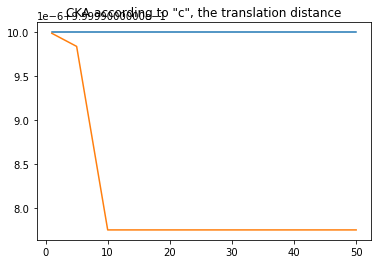

In [9]:
# gauss_trans = np.load('data/two_cubes_exp_lincka2_means_0_1.1_10seeds_v2.npy')
gauss_trans = np.load('data/two_cubes_exp_median0.2_rbfcka2__means_0_1.1_10seeds_v2.npy')
gauss_means = np.mean(gauss_trans,axis=0)

translation_means = np.mean(data, axis = 0)
translation_stds = np.std(data, axis = 0)

# end = 

plt.plot(c_list, translation_means)
plt.plot(c_list, gauss_means)
plt.fill_between(c_list, translation_means-10*translation_stds, translation_means+10*translation_stds, alpha = 0.5)

plt.title('CKA according to "c", the translation distance')

In [ ]:
for i in diff:
    print(len(i[0]))

# Invertible linear transformations

In [58]:
def inv_lin_cka(pts_mean = 0,
                pts_var = 1,
                transform_mean = 0,
                transform_var = 1,
                num_dims = 200,
                num_pts = 10000,
                seed = 0):
    
    np.random.seed(seed)
    rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])
    while np.linalg.cond(rotation_matrix) >= 1/sys.float_info.epsilon:
        rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])

    cuda = torch.device('cuda')
    rotation_matrix = torch.Tensor(rotation_matrix).to(cuda)
    
    X = np.random.normal(pts_mean, pts_var, [num_pts, num_dims])
    X = torch.Tensor(X).to(cuda)
    
    Y = torch.mm(X,rotation_matrix)

    CKA = LinCKA2()
    return CKA(X,Y).item()

In [60]:
num_pts = 10000#, 10000 and 20000 points makes it crash have other things running as well...
num_dims = 500
num_seeds = 10
mu_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]
sigma_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]


data = np.zeros([num_seeds, len(mu_list), len(sigma_list)])
for seed in range(num_seeds):
    print(f'seed {seed}')
    for i1, mu in enumerate(mu_list):
        for i2, sigma in enumerate(sigma_list):
            data[seed, i1, i2] = inv_lin_cka(num_dims = num_dims, num_pts = num_pts, transform_mean=mu, transform_var=sigma, seed = seed)
            
np.save('data/inv_lin_cka_fig_data_lincka2_v0_10k.npy', data)

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [ ]:
data = np.load('data/inv_lin_cka_fig_data_lincka2_v0.npy')

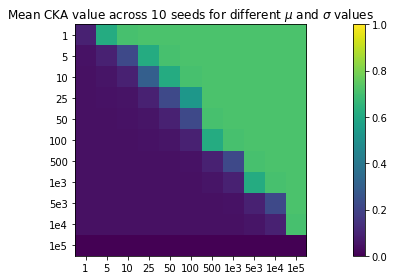

In [61]:
mean_data = np.mean(data, axis = 0)

mu_list_labels = ['1', '5', '10', '25', '50', '100', '500', '1e3', '5e3', '1e4', '1e5']
sigma_list_labels = ['1', '5', '10', '25', '50', '100', '500', '1e3', '5e3', '1e4', '1e5']
     
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_data, interpolation ='nearest', vmin=0, vmax=1)
fig.colorbar(cax)
ax.set_title(r'Mean CKA value across 10 seeds for different $\mu$ and $\sigma$ values')
ax.set_xticks(np.arange(len(sigma_list)))
ax.set_yticks(np.arange(len(mu_list)))
ax.set_xticklabels(sigma_list_labels)
ax.set_yticklabels(mu_list_labels)
ax.axis('image')
# plt.ticklabel_format(axis="x", style="sci")
# plt.ticklabel_format(axis="y", style="sci")
plt.tight_layout()
#         plt.savefig('figures/split_exp_figures_v1/split_class_exp_train_{}pts_'.format(num_pts_cka)+dirr+'.png')

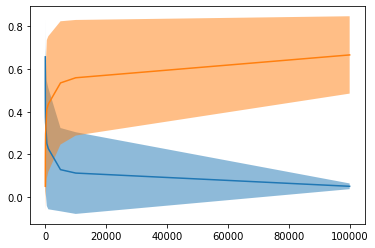

In [6]:
mu_means = np.mean(data, axis = (0,2))
mu_stds = np.std(data, axis = (0,2))
sigma_means = np.mean(data, axis = (0,1))
sigma_stds = np.std(data, axis = (0,1))

mu_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]
sigma_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]


plt.plot(mu_list, mu_means)
plt.fill_between(mu_list, mu_means-mu_stds, mu_means+mu_stds, alpha = 0.5)

plt.plot(sigma_list, sigma_means)
plt.fill_between(sigma_list, sigma_means-sigma_stds, sigma_means+sigma_stds, alpha = 0.5)

# plt.title('CKA according to "c", the translation distance')

# Invertible linear transformations (with cubes)

In [2]:
def inv_lin_cka_cubes(mean1 = 0,
                var1 = 1,
                mean2 = 0,
                var2 = 1,
                transform_mean = 0,
                transform_var = 1,
                num_dims = 200,
                num_pts = 10000,
                seed = 0,
                distribution = 'gaussian'):
    
    np.random.seed(seed)
    rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])
    while np.linalg.cond(rotation_matrix) >= 1/sys.float_info.epsilon:
        rotation_matrix = np.random.normal(transform_mean, transform_var,[num_dims, num_dims])

    cuda = torch.device('cuda')
    rotation_matrix = torch.Tensor(rotation_matrix).to(cuda)
    
    if distribution == 'gaussian':
        X = np.random.normal(mean1, var1, [int(num_pts*2), num_dims])
    elif distribution == 'uniform':
        # in this case var = side and mean = center
        X = np.concatenate([var1*(np.random.rand(num_pts, num_dims)-var1*0.5*np.ones([num_pts,num_dims]))+mean1*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1), var2*(np.random.rand(num_pts, num_dims)-var2*0.5*np.ones([num_pts,num_dims]))+mean2*np.concatenate([np.ones([num_pts,1]),np.zeros([num_pts,num_dims-1])], axis=1)], axis = 0)

    X = torch.Tensor(X).to(cuda)
    Y = torch.mm(X,rotation_matrix)

    CKA = LinCKA2()
    return CKA(X,Y).item()

In [3]:
num_pts = 10000#, 10000 and 20000 points makes it crash have other things running as well...
num_dims = 500
num_seeds = 10
mu_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]
sigma_list = [1, 5, 10, 25, 50, 100, 500, 1000, 5000, 1e4, 1e5]


data = np.zeros([num_seeds, len(mu_list), len(sigma_list)])
for seed in range(num_seeds):
    print(f'seed {seed}')
    for i1, mu in enumerate(mu_list):
        for i2, sigma in enumerate(sigma_list):
            data[seed, i1, i2] = inv_lin_cka_cubes(mean1=0, mean2=1.1,num_dims = num_dims, num_pts = num_pts, transform_mean=mu, transform_var=sigma, seed = seed, distribution = 'uniform')
            
np.save('data/inv_lin_cka_fig_data_lincka2_10k_cubes_means0_1.1.npy', data)

seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6
seed 7
seed 8
seed 9


In [ ]:
data = np.load('data/inv_lin_cka_fig_data_lincka2_v0.npy')

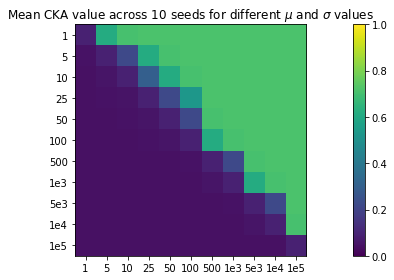

In [5]:
mean_data = np.mean(data, axis = 0)

mu_list_labels = ['1', '5', '10', '25', '50', '100', '500', '1e3', '5e3', '1e4', '1e5']
sigma_list_labels = ['1', '5', '10', '25', '50', '100', '500', '1e3', '5e3', '1e4', '1e5']
     
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_data, interpolation ='nearest', vmin=0, vmax=1)
fig.colorbar(cax)
ax.set_title(r'Mean CKA value across 10 seeds for different $\mu$ and $\sigma$ values')
ax.set_xticks(np.arange(len(sigma_list)))
ax.set_yticks(np.arange(len(mu_list)))
ax.set_xticklabels(sigma_list_labels)
ax.set_yticklabels(mu_list_labels)
ax.axis('image')
# plt.ticklabel_format(axis="x", style="sci")
# plt.ticklabel_format(axis="y", style="sci")
plt.tight_layout()
#         plt.savefig('figures/split_exp_figures_v1/split_class_exp_train_{}pts_'.format(num_pts_cka)+dirr+'.png')

# Non isotropic scaling

In [62]:
def anisotropic_scaling_cka(mean = 0,
                var = 1,
                u_range = 1,
                num_dims = 200,
                num_pts = 10000,
                seed = 0):
    
    cuda = torch.device('cuda')
    
    np.random.seed(seed)
    
    anisotropic_scaling = u_range*np.diag(np.random.rand(num_dims))
    anisotropic_scaling = torch.Tensor(anisotropic_scaling).to(cuda)
    
    X = np.random.normal(mean, var, [num_pts, num_dims])
    X = torch.Tensor(X).to(cuda)
    
    Y = torch.mm(X, anisotropic_scaling)

    CKA = LinCKA2()
    return CKA(X,Y).item()

In [ ]:
# num_pts_list = [100, 500, 1000, 5000, 10000] #20000 points makes it crash
# num_dims_list = [3, 5, 10, 50, 100, 200, 300, 500, 750, 1000, 1500, 2000, 3000]#, 5000, 10000]
# c_list = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 1000]

num_pts_list = [100, 500, 1000, 5000, 10000]
num_dims_list = [5, 50, 100, 300, 500, 1000, 2000]
c_list = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 1000]


data = np.zeros([len(num_pts_list), len(num_dims_list), len(c_list)])
for i1, num_pts in enumerate(num_pts_list):
    for i2, num_dims in enumerate(num_dims_list):
        for i3, c in enumerate(c_list):
            print('Num pts {}; num dims {}; c {}'.format(num_pts, num_dims, c))
            data[i1, i2, i3] = anisotropic_scaling_cka(num_dims = num_dims, num_pts = num_pts, u_range = c)
            
np.save('data/anisotropic_scaling_lincka2_v0.npy', data)

### Analyze results

Text(0.5, 1.0, 'CKA according to "c"')

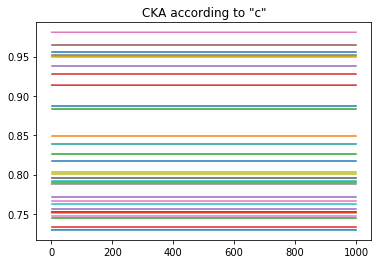

In [64]:
for i in range(len(num_pts_list)):
    for j in range(len(num_dims_list)):
        plt.plot(c_list, data[i,j,:])
        
plt.title('CKA according to "c"')

Text(0.5, 1.0, 'CKA according to the number of dimensions')

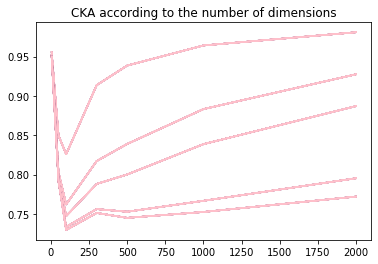

In [65]:
for i in range(len(num_pts_list)):
    for j in range(len(c_list)):
        if j == 0: color = 'r'
        elif j == 1: color = 'g'
        elif j == 2: color = 'b'
        elif j == 3: color = 'purple'
        else: color = 'pink'
        plt.plot(num_dims_list, data[i,:,j], c = color)
        
plt.title('CKA according to the number of dimensions')

Text(0.5, 1.0, 'CKA according to the number of points used to compute CKA')

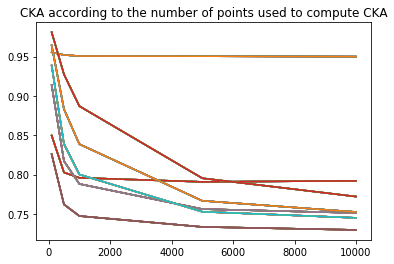

In [66]:
for i in range(len(num_dims_list)):
    for j in range(len(c_list)):
        plt.plot(num_pts_list, data[:,i,j])
        
plt.title('CKA according to the number of points used to compute CKA')